# Progetto Machine Learning - Wine Dataset

In [38]:
# load libraries
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
sns.set()

In [39]:
# load dataset
wine = load_wine()

# create data and target 
X, y = wine.data, wine.target

print(X.shape, y.shape)

(178, 13) (178,)


In [40]:
# print dataset information
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

+ This dataset has a sample size of 178
+ There are 13 continuous numerical features containing information about the chemical profile of the wine 
+ There are three classes of wine, labelled from 0 to 2, corresponding to three different cultivators.

In order to have a first overview of our data, we will make a pairplot, showing:
+ the distribution of each single variable across the three classes
+ the correlation between pairs of variables

This will give us an idea of the variables that will separate the classes the most.

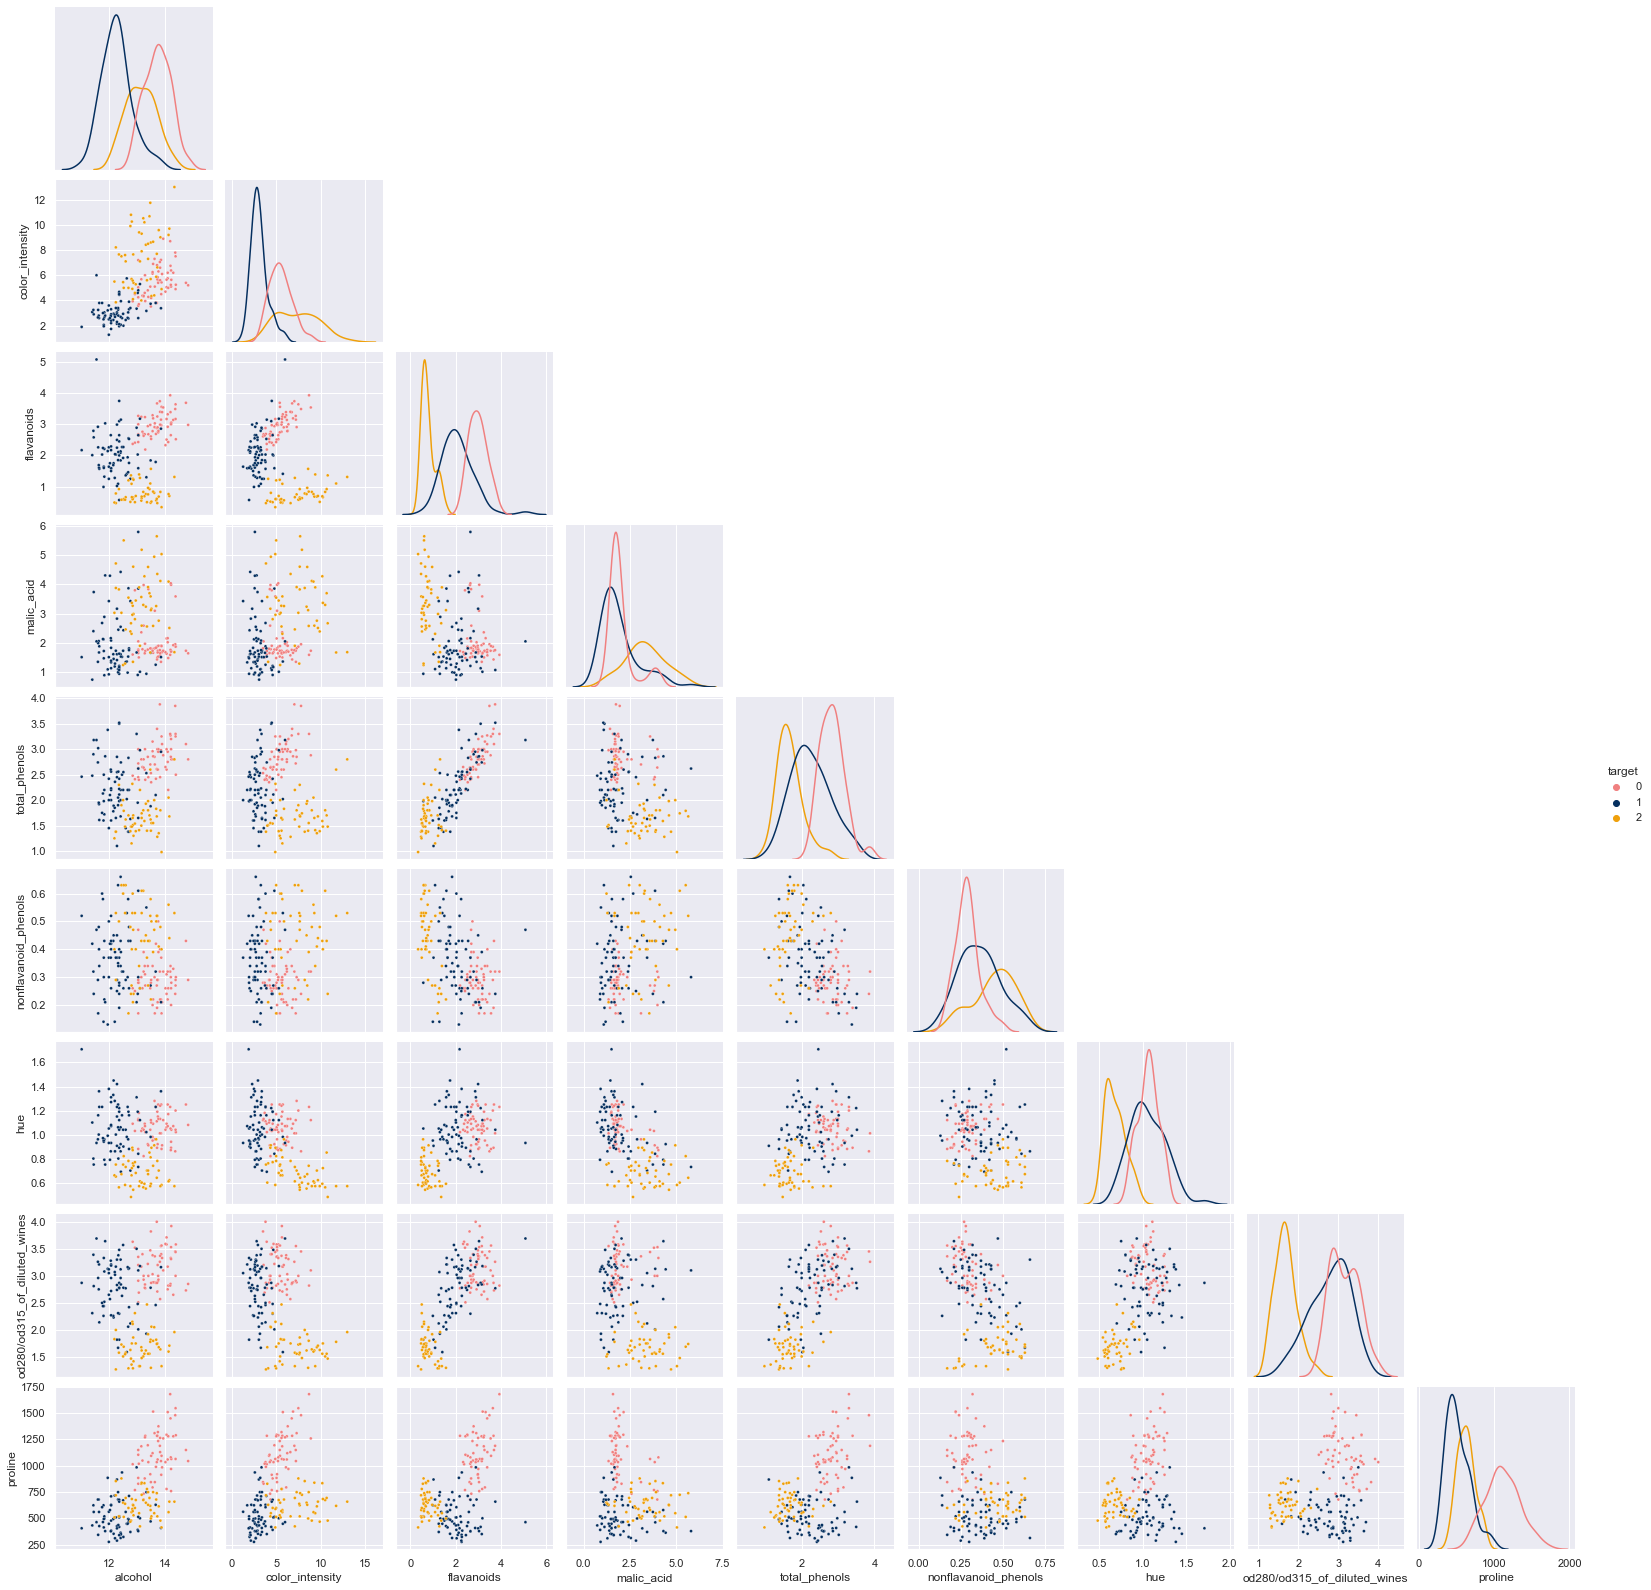

In [41]:
wine_df = load_wine(as_frame=True)
df = pd.DataFrame(wine_df.data, columns=wine.feature_names)
df['target'] = wine_df.target

cols = ['alcohol', 'color_intensity', 'target', 'flavanoids', 'malic_acid', 'total_phenols', 'nonflavanoid_phenols',
        'hue', 'od280/od315_of_diluted_wines', 'proline']

sns.pairplot(df[cols], hue='target',
            corner=True,
            palette={0: '#F08080', 1: '#052F5F', 2: '#EFA00B'},
            diag_kws={'fill': False},
            plot_kws={'s': 9})

For example, it seems that flavanoids and color intensity separate well class 2 and 1 respectively, and this is especially true when the two are combined, whereas class 0 is separated well by proline. 

We are going to use the Random Forest Classifier as the model, which does not require feature scaling. First, we randomly split the dataset into training and test sets.

In [42]:
# split into train and test dataset
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, 
                                                test_size=0.25, 
                                                random_state=42, 
                                                stratify=y) # equal proportion of classes between two sets 

In [43]:
# create model
rf = RandomForestClassifier(oob_score=True, random_state=42)

# show current parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In Random Forest, the main hyperparameter to validate is max_features, which determines the number of features to consider when looking for the best split and determines the amount of bias we accept to insert in the trees.

There are also other parameters we can validate: 
+ n_estimators determines the number of trees in the forest
+ min_samples_split and min_sample_leaf determine the minimum amount of splits and leaves to include in each tree, and if floats they represent percentages


In [44]:
# grid of parameter values to validate
p_grid = [{'max_features': range(1, len(wine.feature_names)),
           'n_estimators': [50, 75, 100],
           'min_samples_split': [0.3, 0.4, 0.5, 0.6]}]

# set up GridSearch
rf_val = GridSearchCV(rf, # estimator
                      param_grid=p_grid, # parameters
                      cv=5,
                      scoring='accuracy')

# train
rf_val.fit(Xtrain, ytrain)

# get best parameters and score
print(rf_val.best_params_)
print(rf_val.best_score_)

{'max_features': 1, 'min_samples_split': 0.3, 'n_estimators': 50}
0.9846153846153847


The Out-of-Bag score is an estimate of generalization capacity and a measure of the goodness of the model, calculated using Out-of-Bag samples. 

The Out of bag sample is a sample that was not included in a given bootstrap sample. We can predict the lablel of an Out-of-bag sample only from the trees that did not use it (due to replacement) to have a measure of how good the model is.

The OOB score is computed as the number of correctly predicted out of bag samples.

In [45]:
# get out of bag score
rf_val.best_estimator_.oob_score_

0.9548872180451128

In this case, the Out-of-bag score is high, indicating a good generalization capacity of the model. 

Now that we have validated the model, we can train it, obtain predictions for the test set and compare predictions with true labels to evaluate its performance.

In [46]:
# get predictions
ypred = rf_val.predict(Xtest)

# evaluate performance
print(metrics.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        12

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



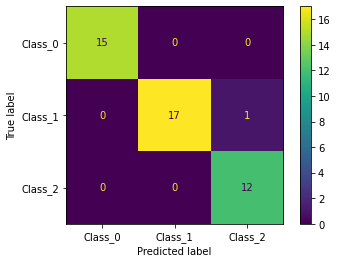

In [47]:
# create a confusion matrix
sns.reset_orig() 
ConfusionMatrixDisplay.from_estimator(rf_val, 
                                      Xtest,
                                      ytest,
                                      display_labels=['Class_0', 'Class_1', 'Class_2'])

We can see from the confusion matrix and classification report that all samples were correctly classified, except for one sample labelled as class_1 which was incorrectly labelled as class_2. 

This also shows in the classification report, as the only class with perfect precision and recall is class_0, whereas precision for class_2 is less than 1 (there was one false positive) and recall for class_1 is less than 1 (there was one false negative). The F1 score is the harmonic mean of the precision and recall.

With Random Forest, we can also evaluate feature importance, which is calculated based on the impurity reduction of each feature and indicates the most important features for classification. 

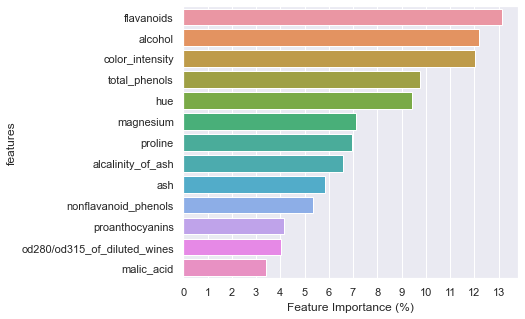

In [51]:
# feature importance as percentage
impo = rf_val.best_estimator_.feature_importances_.reshape((13, 1))*100

# make df of feature importance
fimpo = pd.DataFrame(np.hstack((np.array(wine.feature_names).reshape((13, 1)), impo)), columns=['features', 'importance'])

# set index, change dtype, sort values
fimpo.set_index('features', inplace=True)
fimpo.importance = fimpo.importance.astype('float64')
fimpo.sort_values('importance', inplace=True, ascending=False)

# plot feature importance
sns.set()
fig, ax = plt.subplots(figsize=(6,5))

bar = sns.barplot(x=fimpo.importance, y=fimpo.index, data=fimpo,
            orient='h', ax=ax)

ax.set_xlabel('Feature Importance (%)')

ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

In this case, the most important features for classification were flavanoids, followed by alcohol and color intensity.

However, the impurity-based feature importances computed on tree-based models suffer from two flaws that can lead to misleading conclusions. 
+ They are computed on statistics derived from the training dataset and therefore do not necessarily inform us on which features are most important to make good predictions on held-out dataset. 
+ They favor high cardinality features, the features with many unique values. 

Permutation feature importance is an alternative to impurity-based feature importance that does not suffer from these flaws. This method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important ones. 

We measure the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature. A feature is “important” if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction.

Text(0.5, 0, 'Permutation Importance')

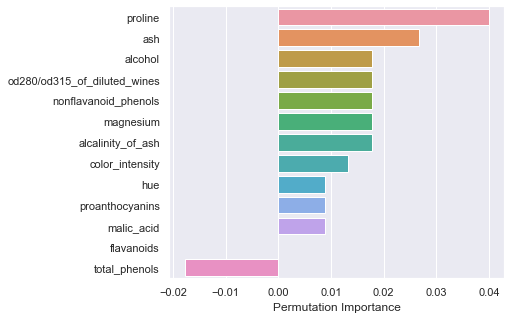

In [52]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf_val, Xtest, ytest)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]

fig = plt.figure(figsize=(6, 5))
bar = sns.barplot(x=perm_importance.importances_mean[sorted_idx], 
                  y=pd.Series(wine.feature_names)[sorted_idx],
                  orient='h')

plt.xlabel("Permutation Importance")

In this case, the important feature resulted to be proline. 

Negative values for permutation importance indicate that the predictions on the shuffled (or noisy) data are more accurate than the real data. This means that the feature does not contribute much to predictions (importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets.